# Final Project: Weather Prediction

In [548]:
#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

# Data at a First-Look

We must first import the data. The set contains useful information,features, and their range as described below:

- Pregnancies: ∈ {0,17}
The number of times the patient has been pregnant

- Glucose: ∈ {0,199}
Plasma glucose concentration in an oral glucose tolerance test

- BloodPressure ∈ {0,122}
Diastolic blood pressure in mm Hg

- SkinThickness ∈ {0,99}
Triceps skin fold thickness in mm

- Insulin ∈ {0,846}
2-hour serum insulin levels in micro Units per millileter

- BMI ∈ {0,67.1}
Body mass index in (weight in kg / (height in m)^2)

- DiabetesPedigreeFunction ∈ {0.078, 2.420000}
A score used to estimate the probability of a person having diabetes based on their family history of the disease

- Age ∈ {21,81}
Age of the patient in years

- Outcome ∈ [0, 1]
1 if the patient has diabetes and 0 otherwise

It is also helpful to see some statistics of the data.

In [549]:
df = pd.read_csv('diabetes.csv')

In [550]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [551]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data Visualization 

<h3>We want to visualize some of our data and their relations in order to better understand our features</h3>

First, we visualize the density and spread of blood pressure and glucose levels with a violin plot

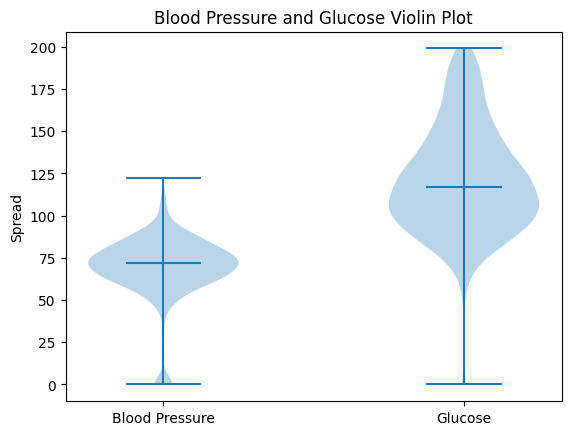

In [552]:
plt.violinplot([df['BloodPressure'],df['Glucose']],showextrema=True,showmedians=True)

plt.title('Blood Pressure and Glucose Violin Plot')
plt.xticks([1,2],['Blood Pressure','Glucose'])
plt.ylabel('Spread')

plt.show()

We can proactively check for any relation between blood pressure and the outcome

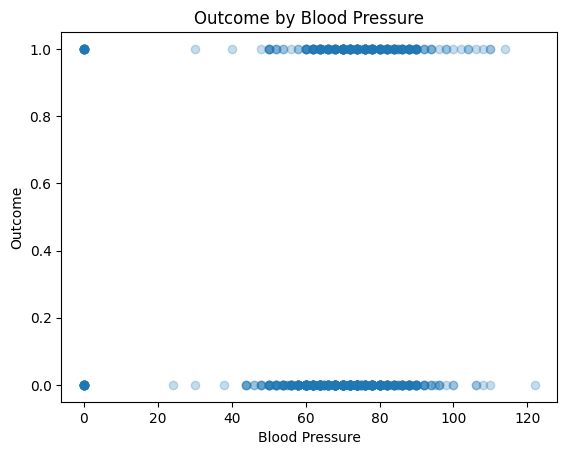

In [553]:
plt.scatter(df['BloodPressure'],df['Outcome'], alpha = 0.25) 
plt.title('Outcome by Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Outcome')

plt.show()

This didn't come out as cleanly as we would have liked. Perhaps we should try putting this data into a histogram separated by whether the outcome was 1 or 0.

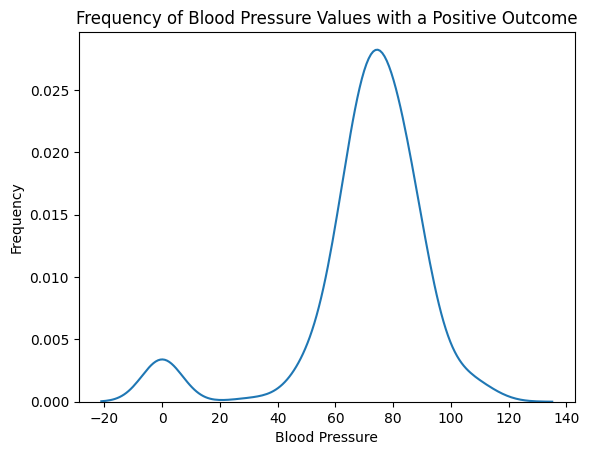

In [554]:
outcome_positive = df.loc[df['Outcome'] == 1]
outcome_negative = df.loc[df['Outcome'] == 0]

density = sns.kdeplot(outcome_positive['BloodPressure'])

plt.title('Frequency of Blood Pressure Values with a Positive Outcome')

plt.xlabel('Blood Pressure')
plt.ylabel('Frequency')

plt.show()

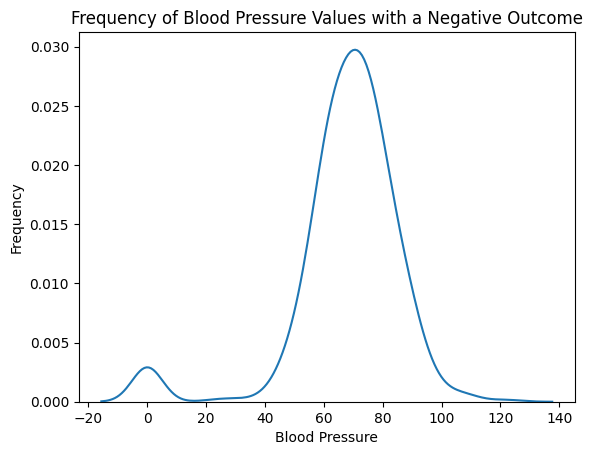

In [555]:
density = sns.kdeplot(outcome_negative['BloodPressure'])

plt.title('Frequency of Blood Pressure Values with a Negative Outcome')

plt.xlabel('Blood Pressure')
plt.ylabel('Frequency')

plt.show()

It looks like both of these distributions have a peak at 0 mm Hg as a blood pressure. As this is highly unlikely for a living individual with a beating heart, we can safely assume that these data points were the result of faulty measurements or were used in place of not having taken a patient's blood pressure. We have a few options here. We could simply remove the bad data points from our set, but other features could also have bad data points, and we don't want to remove too much. 

In [556]:
count = 0
for x in range(len(df['BloodPressure'])):
    if df['BloodPressure'][x] == 0:
        count += 1

print(count)

35


35 out of 768 isn't too much if we wanted to remove it, but let's try something else. What we can try is finding the average of the blood pressure for negative and positive outcomes without the zero data points included and then set these points to their respective averages. 

In [557]:
pos = df.loc[(df['Outcome'] == 1) & (df['BloodPressure'] > 0)]
print(pos['BloodPressure'].mean())

neg = df.loc[(df['Outcome'] == 0) & (df['BloodPressure'] > 0)]
print(neg['BloodPressure'].mean())

75.32142857142857
70.87733887733887


Looking at the first 10 data points, we see that the seventh data point has 0 for Blood Pressure and 0 for the outcome. After updating our data points, we expect the blood pressure for the seventh data point to be 70.87733887733887

In [558]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [559]:
for x in range(len(df['BloodPressure'])):
    if df['BloodPressure'][x] == 0 & df['Outcome'][x] == 1:
        df['BloodPressure'][x] = 75.32142857142857
    if df['BloodPressure'][x] == 0 & df['Outcome'][x] == 0: 
        df['BloodPressure'][x] = 70.87733887733887

/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/2191140408.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['BloodPressure'][x] = 70.87733887733887
/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/21911

In [560]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.000000,35,0,33.6,0.627,50,1
1,1,85,66.000000,29,0,26.6,0.351,31,0
2,8,183,64.000000,0,0,23.3,0.672,32,1
3,1,89,66.000000,23,94,28.1,0.167,21,0
4,0,137,40.000000,35,168,43.1,2.288,33,1
5,5,116,74.000000,0,0,25.6,0.201,30,0
6,3,78,50.000000,32,88,31.0,0.248,26,1
7,10,115,70.877339,0,0,35.3,0.134,29,0
8,2,197,70.000000,45,543,30.5,0.158,53,1
9,8,125,96.000000,0,0,0.0,0.232,54,1


As we can see, the seventh data point has been replaced with the average blood pressure of the patients with a negative outcome. Let's look at our density distributions again with our new data.

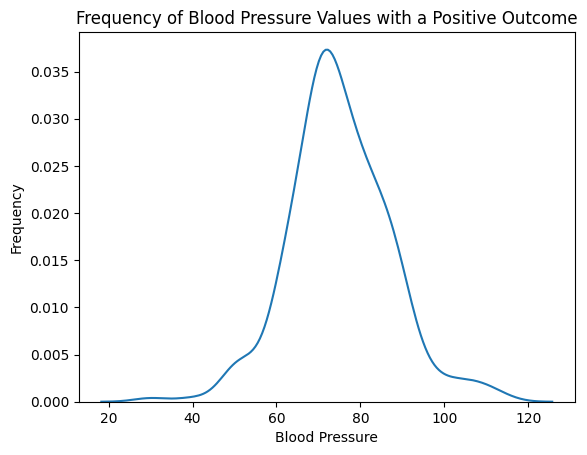

In [561]:
outcome_positive = df.loc[df['Outcome'] == 1]
outcome_negative = df.loc[df['Outcome'] == 0]

density = sns.kdeplot(outcome_positive['BloodPressure'])

plt.title('Frequency of Blood Pressure Values with a Positive Outcome')

plt.xlabel('Blood Pressure')
plt.ylabel('Frequency')

plt.show()

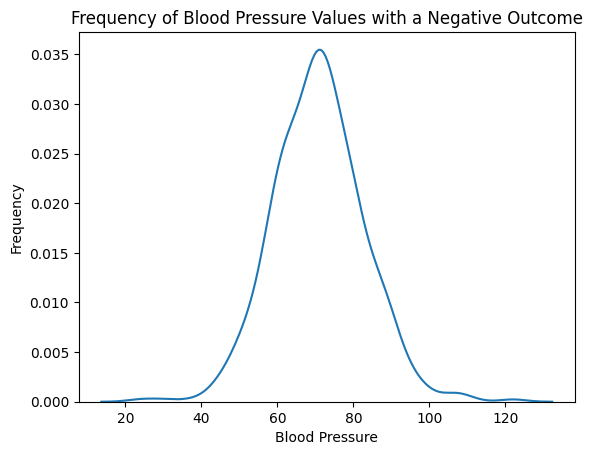

In [562]:
density = sns.kdeplot(outcome_negative['BloodPressure'])

plt.title('Frequency of Blood Pressure Values with a Negative Outcome')

plt.xlabel('Blood Pressure')
plt.ylabel('Frequency')

plt.show()

These look more reliable. Now, let's return to our glucose data.

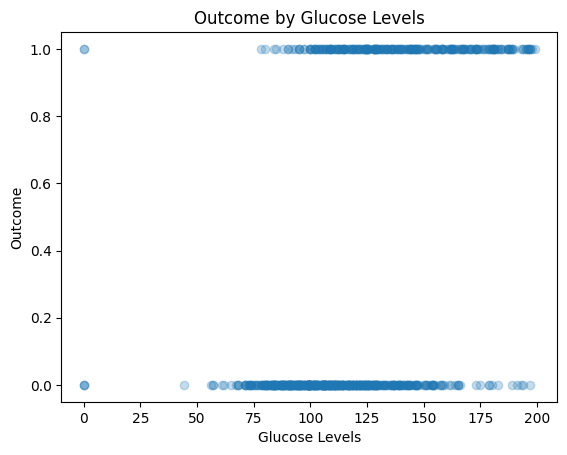

In [563]:
plt.scatter(df['Glucose'],df['Outcome'], alpha = 0.25) 
plt.title('Outcome by Glucose Levels')
plt.xlabel('Glucose Levels')
plt.ylabel('Outcome')

plt.show()

It looks like glucose levels might have the same issue where some data points are 0, which is highly unlikely for a living person. Let's use the same process to clean up some of this data.

In [564]:
pos = df.loc[(df['Outcome'] == 1) & (df['Glucose'] > 0)]
print(pos['Glucose'].mean())

neg = df.loc[(df['Outcome'] == 0) & (df['Glucose'] > 0)]
print(neg['Glucose'].mean())

for x in range(len(df['Glucose'])):
    if df['Glucose'][x] == 0 & df['Outcome'][x] == 1:
        df['Glucose'][x] = 142.31954887218046
    if df['Glucose'][x] == 0 & df['Outcome'][x] == 0: 
        df['Glucose'][x] = 110.64386317907444

142.31954887218046
110.64386317907444


/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/3414091287.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Glucose'][x] = 110.64386317907444
/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/341409128

After updating our data points, let's visualize the data again.

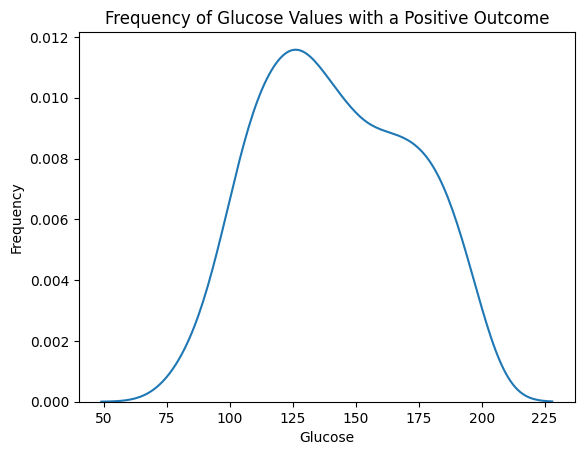

In [565]:
outcome_positive = df.loc[df['Outcome'] == 1]
outcome_negative = df.loc[df['Outcome'] == 0]

density = sns.kdeplot(outcome_positive['Glucose'])

plt.title('Frequency of Glucose Values with a Positive Outcome')

plt.xlabel('Glucose')
plt.ylabel('Frequency')

plt.show()

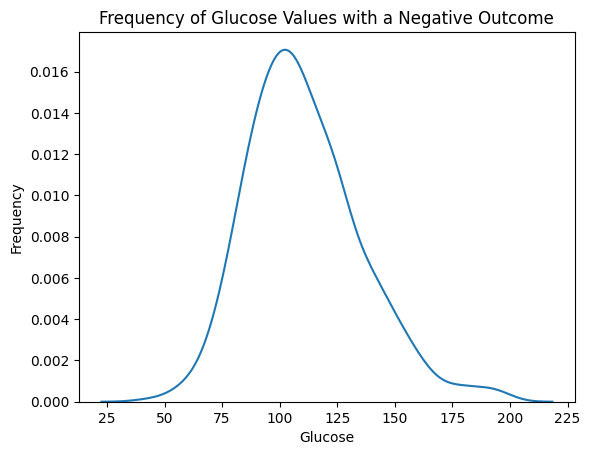

In [566]:
density = sns.kdeplot(outcome_negative['Glucose'])

plt.title('Frequency of Glucose Values with a Negative Outcome')

plt.xlabel('Glucose')
plt.ylabel('Frequency')

plt.show()

These distributions look more reliable, and it looks like there's a nicer difference here between the distribution of glucose levels with a positive outcome and those with a negative outcome.

Let's see if any other features need to be updated.

In [567]:
has_zero = df['SkinThickness'].isin([0]).any()
print(has_zero)
has_zero = df['BMI'].isin([0]).any()
print(has_zero)
has_zero = df['Age'].isin([0]).any()
print(has_zero)

True
True
False


It looks like we have to update the data points for Skin Thickness and BMI too. 

In [568]:
pos = df.loc[(df['Outcome'] == 1) & (df['SkinThickness'] > 0)]
print(pos['SkinThickness'].mean())

neg = df.loc[(df['Outcome'] == 0) & (df['SkinThickness'] > 0)]
print(neg['SkinThickness'].mean())

for x in range(len(df['SkinThickness'])):
    if df['SkinThickness'][x] == 0 & df['Outcome'][x] == 1:
        df['SkinThickness'][x] = pos['SkinThickness'].mean()
    if df['SkinThickness'][x] == 0 & df['Outcome'][x] == 0: 
        df['SkinThickness'][x] = neg['SkinThickness'].mean()

33.0
27.235457063711912


/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/2580355350.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['SkinThickness'][x] = neg['SkinThickness'].mean()
/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_

In [569]:
pos = df.loc[(df['Outcome'] == 1) & (df['BMI'] > 0)]
print(pos['BMI'].mean())

neg = df.loc[(df['Outcome'] == 0) & (df['BMI'] > 0)]
print(neg['BMI'].mean())

for x in range(len(df['BMI'])):
    if df['BMI'][x] == 0 & df['Outcome'][x] == 1:
        df['BMI'][x] = pos['BMI'].mean()
    if df['BMI'][x] == 0 & df['Outcome'][x] == 0: 
        df['BMI'][x] = neg['BMI'].mean()

35.40676691729323
30.859674134419553


/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/574498482.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['BMI'][x] = neg['BMI'].mean()
/var/folders/m1/8pnx8_x935z40n4qyy5p2zz40000gn/T/ipykernel_62461/574498482.py:11

We can also visualize the relation of all of our data points with the outcome through a heat map.

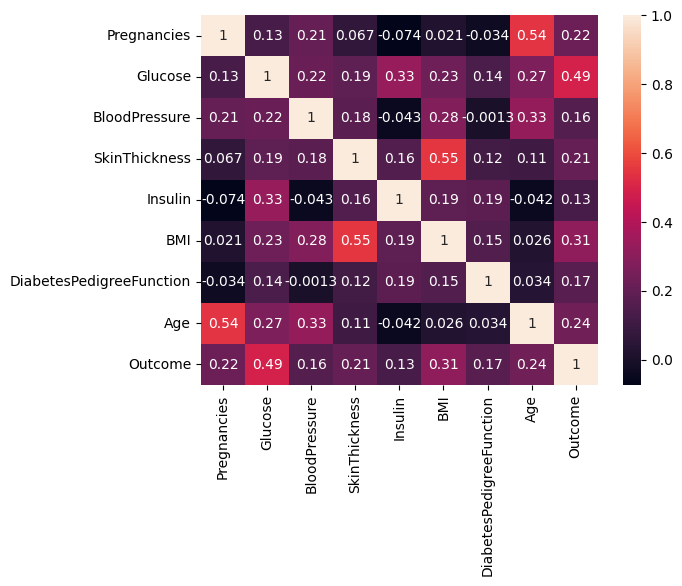

In [570]:
corr = df.corr() 
sns.heatmap(corr, annot=True) 
plt.show()

# Models

<h3>We can try a few different models to see which gives us a better predictive accuracy</h3>

First, we can look at a KNeighbors Classifier. This might not be as helpful due to the fact that our data is not categorical, but hopefully the classifier can create some useful boundaries for our continous data and still give us a valid prediction.

In [571]:
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
Y = df['Outcome']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

KNN = KNeighborsClassifier()
KNN.fit(X_train, Y_train)


predictions = KNN.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, predictions))

Accuracy:  0.6948051948051948


Now, we can try using a decision tree. Instead of manually inputting a depth, we can check which depth gives the best accuracy and input that later.

In [572]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter
# Modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score

import lightgbm as lgb

# Hyperparameter tuning
from hyperopt import fmin, rand, tpe, space_eval, STATUS_OK, Trials, hp
from hyperopt.pyll.stochastic import sample
# from bayes_opt import BayesianOptimization
# import optuna

params = {
    'max_depth': 5,
    'objective': 'binary',
    'metric': 'auc',
    'force_col_wise': True,
    'verbose': -1
}

# Train and evaluate
train_data = lgb.Dataset(X_train, label=Y_train)
clf = lgb.train(params, train_data, num_boost_round=3)

#valid_data = lgb.Dataset(X_test, label=Y_test)

# clf = lgb.train(
#     params,
#     train_data,
#     num_boost_round=500,  # use large number, let early stopping cut it off
#     valid_sets=[train_data, train_data],
#     valid_names=['train', 'valid'],
#     early_stopping_rounds=50,
#     verbose_eval=False
# )

y_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

# ROC AUC Score
roc_auc2 = roc_auc_score(Y_train, y_train)
roc_auc = roc_auc_score(Y_test, y_pred)
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# best_depth = 1      
# best_accuracy = 0   
# for k in range(1, 100):
#     model = tree.DecisionTreeClassifier(max_depth = k)
#     model.fit(X_train, Y_train)

#     pred_test = model.predict(X_test)
#     acc_test = accuracy_score(pred_test, Y_test)

#     if acc_test > best_accuracy :
#         best_accuracy = acc_test
#         best_depth = k

# print(best_accuracy)
# print(best_depth)

ROC AUC: 0.9033
ROC AUC: 0.8147


Here we use a decision tree to test our training and testing accuracy. Our training accuracy is usually lower or at least close to our test accuracy, so the model isn't overfitting too badly to our training data points.

In [573]:
model = tree.DecisionTreeClassifier(max_depth = 5)

model.fit(X_train, Y_train)

dtree_pred_train = model.predict(X_train)
dtree_pred_test = model.predict(X_test)
print("Train Accuracy: ", accuracy_score(dtree_pred_train, Y_train))
print("Test Accuracy: ", accuracy_score(dtree_pred_test, Y_test))

Train Accuracy:  0.8208469055374593
Test Accuracy:  0.7532467532467533
